In [1]:
import sys, subprocess, pkgutil

In [2]:

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

In [3]:
req = ["pandas","numpy","torch","tqdm","matplotlib","nltk","spacy", "pyarrow"]
to_install = [p for p in req if pkgutil.find_loader(p) is None]
if to_install:
    pip_install(to_install)

C:\Users\DIEAL\AppData\Local\Temp\ipykernel_28276\3958940768.py:2: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  to_install = [p for p in req if pkgutil.find_loader(p) is None]


In [4]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DIEAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# spaCy español (para co-referencia sencilla)
try:
    import es_core_news_sm
    nlp = es_core_news_sm.load()
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
    import es_core_news_sm
    nlp = es_core_news_sm.load()

print("OK: dependencias listas.")

OK: dependencias listas.


In [6]:
import pandas as pd, numpy as np, os, ast

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

df = pd.read_parquet("data/processed/preprocesado.parquet")
df = df.dropna(subset=["text_norm","tokens"]).reset_index(drop=True)

tokens = df["tokens"].tolist()
if isinstance(tokens[0], str):
    tokens = [ast.literal_eval(t) for t in tokens]

print("Docs:", len(tokens))
print("Ejemplo tokens:", tokens[0][:20])

Docs: 10200
Ejemplo tokens: ['valladolid' 'misteriosa' 'titulo' 'nuevo' 'libro' 'acaba' 'publicar'
 'editorial' 'almuzara' 'trata' 'obra' 'investigador' 'paranormal' 'juan'
 'carlos' 'pasalodos' 'perez' 'realiza' 'exhaustiva' 'recopilacion']


In [7]:
from collections import Counter

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

def build_vocab(token_lists, min_freq=5, max_size=None):
    counter = Counter(t for doc in token_lists for t in doc)
    # Filtramos por frecuencia mínima
    words = [w for w, c in counter.items() if c >= min_freq]
    # Orden por frecuencia
    words = sorted(words, key=lambda w: -counter[w])
    if max_size is not None:
        words = words[:max_size]
    itos = [PAD, BOS, EOS, UNK] + words
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos

stoi, itos = build_vocab(tokens, min_freq=3, max_size=20000)
vocab_size = len(itos)
print("Vocab size:", vocab_size)

def numericalize(doc, stoi_map, add_bos=False, add_eos=True):
    idxs = []
    if add_bos:
        idxs.append(stoi_map[BOS])
    for t in doc:
        idxs.append(stoi_map.get(t, stoi_map[UNK]))
    if add_eos:
        idxs.append(stoi_map[EOS])
    return idxs

num_docs = [numericalize(doc, stoi) for doc in tokens]
print("Ejemplo numérico:", num_docs[0][:20])

Vocab size: 20004
Ejemplo numérico: [3342, 10592, 930, 30, 1046, 792, 7409, 5087, 3, 129, 845, 3857, 3, 465, 703, 3, 1252, 1037, 13457, 8163]


In [9]:
from sklearn.model_selection import train_test_split

train_docs, test_docs = train_test_split(num_docs, test_size=0.1, random_state=42)
train_docs, val_docs  = train_test_split(train_docs, test_size=0.1, random_state=42)

len(train_docs), len(val_docs), len(test_docs)

# %%
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class LanguageModelDataset(Dataset):
    def __init__(self, docs, seq_len=30):
        self.seq_len = seq_len
        self.samples = []
        for doc in docs:
            if len(doc) < 2:
                continue
            # creamos pares (input, target) por sliding window
            for i in range(0, len(doc)-1-seq_len, seq_len):
                inp = doc[i:i+seq_len]
                tgt = doc[i+1:i+seq_len+1]
                self.samples.append((inp, tgt))
        self.length = len(self.samples)
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        inp, tgt = self.samples[idx]
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

SEQ_LEN = 30
train_ds = LanguageModelDataset(train_docs, seq_len=SEQ_LEN)
val_ds   = LanguageModelDataset(val_docs,   seq_len=SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

len(train_ds), len(val_ds)

Device: cpu


(98127, 10387)

In [10]:
import torch.nn as nn
from tqdm.auto import tqdm
import math

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        emb = self.embedding(x)              # [B, T, E]
        out, hidden = self.rnn(emb, hidden)  # [B, T, H]
        logits = self.fc(out)                # [B, T, V]
        return logits, hidden

def train_language_model(model, train_loader, val_loader, epochs=3, lr=1e-3):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=stoi[PAD])
    best_val = float("inf")
    for ep in range(1, epochs+1):
        model.train()
        total_loss, total_tokens = 0.0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {ep} [train]"):
            x, y = x.to(device), y.to(device)
            optim.zero_grad()
            logits, _ = model(x)
            # logits: [B, T, V], y: [B, T]
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            total_loss += loss.item() * y.numel()
            total_tokens += y.numel()
        train_loss = total_loss / total_tokens
        train_ppl = math.exp(train_loss)
        # validación
        model.eval()
        val_loss, val_tok = 0.0, 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Epoch {ep} [val]"):
                x, y = x.to(device), y.to(device)
                logits, _ = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                val_loss += loss.item() * y.numel()
                val_tok += y.numel()
        val_loss /= val_tok
        val_ppl = math.exp(val_loss)
        print(f"Epoch {ep}: train_loss={train_loss:.4f} (ppl={train_ppl:.2f}) | "
              f"val_loss={val_loss:.4f} (ppl={val_ppl:.2f})")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "models/rnn_lm.pt")
            print("   >> mejor modelo RNN guardado.")

rnn_model = RNNLanguageModel(vocab_size)
train_language_model(rnn_model, train_loader, val_loader, epochs=2, lr=1e-3)

C:\Users\DIEAL\OneDrive\Desktop\Coding\NLP-proyecto2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1 [val]: 100%|██████████| 163/163 [00:09<00:00, 16.85it/s]


Epoch 1: train_loss=7.7327 (ppl=2281.66) | val_loss=7.3946 (ppl=1627.10)
   >> mejor modelo RNN guardado.


Epoch 2 [val]: 100%|██████████| 163/163 [00:09<00:00, 16.77it/s]

Epoch 2: train_loss=6.9341 (ppl=1026.67) | val_loss=7.1513 (ppl=1275.77)
   >> mejor modelo RNN guardado.


In [11]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        logits = self.fc(out)
        return logits, hidden

lstm_model = LSTMLanguageModel(vocab_size)
train_language_model(lstm_model, train_loader, val_loader, epochs=2, lr=1e-3)
torch.save(lstm_model.state_dict(), "models/lstm_lm.pt")
print("OK → models/lstm_lm.pt")

Epoch 1 [val]: 100%|██████████| 163/163 [00:11<00:00, 13.81it/s]


Epoch 1: train_loss=8.0667 (ppl=3186.47) | val_loss=7.8372 (ppl=2532.99)
   >> mejor modelo RNN guardado.


Epoch 2 [val]: 100%|██████████| 163/163 [00:10<00:00, 15.38it/s]

Epoch 2: train_loss=7.5564 (ppl=1912.86) | val_loss=7.3866 (ppl=1614.23)
   >> mejor modelo RNN guardado.
OK → models/lstm_lm.pt


In [12]:
import random

def generate_text(model, stoi_map, itos_list, start_text="el", max_len=30, temperature=1.0):
    model.eval()
    model.to(device)
    # tokenizamos start_text usando tu vocab
    start_tokens = start_text.strip().split()
    idxs = [stoi_map.get(t, stoi_map[UNK]) for t in start_tokens]
    x = torch.tensor([idxs], dtype=torch.long).to(device)
    hidden = None
    with torch.no_grad():
        logits, hidden = model(x, hidden)
        # tomamos solo el último paso
        next_input = x[:, -1:]
        generated = list(idxs)
        for _ in range(max_len):
            logits, hidden = model(next_input, hidden)
            logits_step = logits[:, -1, :] / temperature
            probs = torch.softmax(logits_step, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_id = next_token.item()
            generated.append(token_id)
            next_input = next_token
            if itos_list[token_id] == EOS:
                break
    return " ".join(itos_list[i] for i in generated if i not in [stoi_map[EOS], stoi_map[PAD]])

print("Ejemplo generación RNN:",
      generate_text(rnn_model, stoi, itos, start_text="el gobierno", max_len=20))
print("Ejemplo generación LSTM:",
      generate_text(lstm_model, stoi, itos, start_text="la economia", max_len=20))

Ejemplo generación RNN: <unk> gobierno aprobo <unk> martin lesiones <unk> continuo serie <unk> alto eva <unk> <unk> centro webb afectado protegido algoritmos correr drone guard
Ejemplo generación LSTM: <unk> economia acelerador cobra <unk> negativo mas perjudicar cierto representantes director interna <unk> <unk> paneles emisiones vida <unk> necesitan sol habia traves


In [13]:
MAX_LEN_SRC = 25
MAX_LEN_TGT = 25

pairs = []
for doc in tokens:
    if len(doc) < 4:
        continue
    src = doc[:MAX_LEN_SRC]
    tgt = doc[:MAX_LEN_TGT]
    src_idx = numericalize(src, stoi, add_bos=True, add_eos=True)
    tgt_idx = numericalize(tgt, stoi, add_bos=True, add_eos=True)
    pairs.append((src_idx, tgt_idx))

print("Pares Seq2Seq:", len(pairs))

train_pairs, test_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs  = train_test_split(train_pairs, test_size=0.1, random_state=42)

len(train_pairs), len(val_pairs), len(test_pairs)

Pares Seq2Seq: 10200


(8262, 918, 1020)

In [14]:
class Seq2SeqDataset(Dataset):
    def __init__(self, pairs, max_src_len=MAX_LEN_SRC+2, max_tgt_len=MAX_LEN_TGT+2):
        self.pairs = pairs
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        # trunc / pad
        src = src[:self.max_src_len]
        tgt = tgt[:self.max_tgt_len]
        src_pad = src + [stoi[PAD]]*(self.max_src_len - len(src))
        tgt_pad = tgt + [stoi[PAD]]*(self.max_tgt_len - len(tgt))
        return torch.tensor(src_pad, dtype=torch.long), torch.tensor(tgt_pad, dtype=torch.long)

seq_train_ds = Seq2SeqDataset(train_pairs)
seq_val_ds   = Seq2SeqDataset(val_pairs)
seq_test_ds  = Seq2SeqDataset(test_pairs)

seq_train_loader = DataLoader(seq_train_ds, batch_size=32, shuffle=True)
seq_val_loader   = DataLoader(seq_val_ds,   batch_size=32)

In [15]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0.0)
    def forward(self, src, src_len=None):
        # src: [B, T]
        emb = self.embedding(src)
        outputs, (h, c) = self.lstm(emb)
        # outputs: [B, T, H]
        return outputs, (h, c)

class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.scale = 1.0 / math.sqrt(hidden_dim)
    def forward(self, query, enc_outputs, mask=None):
        # query: [B, H]
        # enc_outputs: [B, T, H]
        # score = q·h
        scores = torch.bmm(enc_outputs, query.unsqueeze(2)).squeeze(2)  # [B, T]
        scores = scores * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn_weights = torch.softmax(scores, dim=1)  # [B, T]
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)  # [B, H]
        return context, attn_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.attn = LuongAttention(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim*2, vocab_size)
    def forward(self, input_step, hidden, enc_outputs, mask=None, return_attn=False):
        # input_step: [B] -> [B,1]
        emb = self.embedding(input_step.unsqueeze(1))   # [B, 1, E]
        out, hidden = self.lstm(emb, hidden)           # out: [B,1,H]
        out = out.squeeze(1)                           # [B,H]
        # atención
        context, attn_w = self.attn(out, enc_outputs, mask)
        concat = torch.cat([out, context], dim=-1)     # [B,2H]
        logits = self.fc_out(concat)                   # [B,V]
        if return_attn:
            return logits, hidden, attn_w
        return logits, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx=0, bos_idx=1, eos_idx=2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [B,Ts], tgt: [B,Tt]
        B, Tt = tgt.size()
        enc_outputs, (h, c) = self.encoder(src)
        # primer input del decoder = BOS
        outputs = []
        input_step = tgt[:,0]  # asumimos que la primera posición es BOS
        hidden = (h, c)
        for t in range(1, Tt):
            logits, hidden = self.decoder(input_step, hidden, enc_outputs)
            outputs.append(logits.unsqueeze(1))
            # decodificación con teacher forcing
            use_tf = (torch.rand(1).item() < teacher_forcing_ratio)
            top1 = logits.argmax(dim=-1)
            input_step = tgt[:,t] if use_tf else top1
        # outputs: lista de [B,1,V] → [B,Tt-1,V]
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [16]:
enc = Encoder(vocab_size)
dec = Decoder(vocab_size)
seq2seq_model = Seq2Seq(enc, dec, pad_idx=stoi[PAD], bos_idx=stoi[BOS], eos_idx=stoi[EOS]).to(device)

def train_seq2seq(model, train_loader, val_loader, epochs=3, lr=1e-3, teacher_forcing_ratio=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=stoi[PAD])
    best_val = float("inf")
    for ep in range(1, epochs+1):
        model.train()
        total_loss, total_tokens = 0.0, 0
        for src, tgt in tqdm(train_loader, desc=f"Seq2Seq Epoch {ep} [train]"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            outputs = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio)
            # outputs: [B, Tt-1, V], tgt_target: [B, Tt-1]
            tgt_target = tgt[:, 1:]
            loss = criterion(outputs.reshape(-1, vocab_size), tgt_target.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item() * tgt_target.numel()
            total_tokens += tgt_target.numel()
        train_loss = total_loss / total_tokens
        # validación
        model.eval()
        val_loss, val_tokens = 0.0, 0
        with torch.no_grad():
            for src, tgt in tqdm(val_loader, desc=f"Seq2Seq Epoch {ep} [val]"):
                src, tgt = src.to(device), tgt.to(device)
                outputs = model(src, tgt, teacher_forcing_ratio=0.0)
                tgt_target = tgt[:, 1:]
                loss = criterion(outputs.reshape(-1, vocab_size), tgt_target.reshape(-1))
                val_loss += loss.item() * tgt_target.numel()
                val_tokens += tgt_target.numel()
        val_loss /= val_tokens
        print(f"Epoch {ep}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "models/seq2seq_attention.pt")
            print("   >> mejor modelo Seq2Seq+Atención guardado.")

train_seq2seq(seq2seq_model, seq_train_loader, seq_val_loader, epochs=2, lr=1e-3, teacher_forcing_ratio=0.6)


Seq2Seq Epoch 1 [val]: 100%|██████████| 29/29 [00:05<00:00,  5.38it/s]


Epoch 1: train_loss=8.0206 | val_loss=7.7848
   >> mejor modelo Seq2Seq+Atención guardado.


Seq2Seq Epoch 2 [val]: 100%|██████████| 29/29 [00:05<00:00,  5.37it/s]


Epoch 2: train_loss=7.4251 | val_loss=7.4048
   >> mejor modelo Seq2Seq+Atención guardado.


SRC: <bos> palmas gran canaria feb efe ministra transicion ecologica teresa ribera considera justicia promover isla gran canaria convierta <unk> tecnologica despliegue espana parques energia eolica marina <eos>
DEC: <bos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


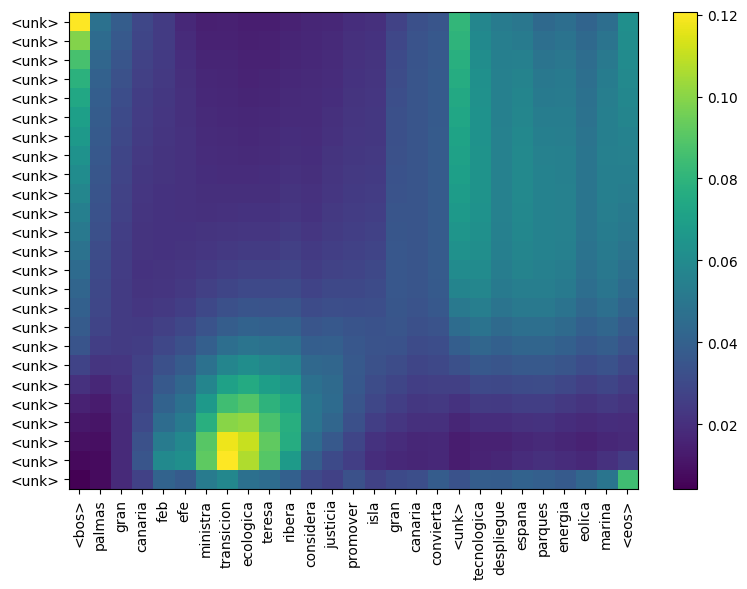

Mapa de atención guardado en figures/attention_example.png


In [17]:
import matplotlib.pyplot as plt

def greedy_decode_with_attention(model, src_seq):
    model.eval()
    with torch.no_grad():
        src = src_seq.unsqueeze(0).to(device)  # [1,Ts]
        enc_outputs, (h, c) = model.encoder(src)
        B, Ts, H = enc_outputs.shape
        mask = (src != stoi[PAD]).to(device)   # [1,Ts]
        # primer token BOS
        input_step = torch.full((1,), model.bos_idx, dtype=torch.long, device=device)
        hidden = (h, c)
        decoded = [model.bos_idx]
        attn_matrix = []
        for _ in range(MAX_LEN_TGT):
            logits, hidden, attn_w = model.decoder(input_step, hidden, enc_outputs, mask=mask, return_attn=True)
            token_id = logits.argmax(dim=-1).item()
            decoded.append(token_id)
            attn_matrix.append(attn_w.squeeze(0).cpu().numpy())  # [Ts]
            input_step = torch.tensor([token_id], dtype=torch.long, device=device)
            if token_id == model.eos_idx:
                break
        return decoded, np.stack(attn_matrix, axis=0) if attn_matrix else None, src_seq.cpu().numpy()

# ejemplo
sample_src, sample_tgt = seq_test_ds[0]
decoded_ids, attn_mat, src_ids = greedy_decode_with_attention(seq2seq_model, sample_src)

src_tokens = [itos[i] for i in src_ids if i not in [stoi[PAD]]]
dec_tokens = [itos[i] for i in decoded_ids if i not in [stoi[PAD]]]

print("SRC:", " ".join(src_tokens))
print("DEC:", " ".join(dec_tokens))

if attn_mat is not None:
    plt.figure(figsize=(8,6))
    plt.imshow(attn_mat[:, :len(src_tokens)], aspect='auto', origin='lower')
    plt.colorbar()
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(dec_tokens)-1), dec_tokens[1:])  # sin BOS
    plt.tight_layout()
    plt.savefig("figures/attention_example.png", dpi=160)
    plt.show()
    print("Mapa de atención guardado en figures/attention_example.png")


In [55]:
import re
import spacy

# Asegúrate de tener el modelo de spaCy cargado
try:
    nlp = spacy.load("es_core_news_md")
except OSError:
    print("Descargando modelo 'es_core_news_md'...")
    spacy.cli.download("es_core_news_md")
    nlp = spacy.load("es_core_news_md")

# 1. Conjunto ampliado de pronombres a buscar (Tercera Persona, sujeto y objeto clítico)
PRON_PERSONAS = {"él", "el", "ella", "ellos", "ellas", "le", "lo", "la", "los", "las"}

# Roles nominales típicos (Singular)
ROLES_NOMINALES = {
    "ministro", "ministra", "presidente", "presidenta",
    "portavoz", "actor", "actriz", "escritor", "escritora",
    "juez", "jueza"
}

# --- Funciones Auxiliares ---

def limpiar_nombre(nombre: str) -> str:
    """Quita puntuación."""
    return nombre.strip(" .,:;!?«»\"'()")

def get_gender_number(tok) -> tuple[str, str]:
    """
    Intenta obtener Género y Número del token usando spaCy.
    Devuelve (Género, Número), Ej: ('Masc', 'Sing') o ('Masc', 'Plur')
    """
    # 1. Intentar con atributos morfológicos directos
    gender = tok.morph.get('Gender')
    number = tok.morph.get('Number')

    if gender and number:
        return gender[0], number[0] # Ej: ('Masc', 'Sing')

    # 2. Heurística para Nombres Propios (si spaCy no lo dio)
    if tok.pos_ == "PROPN":
        nombre = tok.text.lower()
        if nombre.endswith("a"):
            return "Fem", "Sing"
        if nombre.endswith("s"): # Heurística muy simple para plurales de NER no resueltos
            return "Masc", "Plur"
        return "Masc", "Sing" # Asume Masculino Singular por defecto

    # 3. Fallback (para objetos/conceptos)
    return "Masc", "Sing" # Default: Masc Sing para entidades no personales no capturadas

def get_pronoun_type(tok) -> str | None:
    """Clasifica el pronombre: Masc_Sing, Fem_Sing, Masc_Plur, Fem_Plur"""
    t = tok.text.lower()
    g, n = get_gender_number(tok)

    # Manejar "el" como pronombre (ej. "él habló") vs. "el" como determinante
    if tok.pos_ == "PRON":
        if g and n:
            return f"{g}_{n}"

    # Regla manual para pronombres comunes no capturados totalmente por .morph
    if t in ("él", "el"): return "Masc_Sing"
    if t == "ella": return "Fem_Sing"
    if t == "ellos": return "Masc_Plur"
    if t == "ellas": return "Fem_Plur"
    if t in ("le", "lo"): return "Masc_Sing"
    if t == "la": return "Fem_Sing"
    if t == "los": return "Masc_Plur"
    if t == "las": return "Fem_Plur"

    return None

# --- Función Principal ---

def simple_coref_resolve(text: str) -> str:
    doc = nlp(text)

    # Memoria del último antecedente por género y número (4 estados)
    ultimo_antecedente: dict[str, str | None] = {
        "Masc_Sing": None, "Fem_Sing": None,
        "Masc_Plur": None, "Fem_Plur": None
    }

    # Lista global de antecedentes: (posición_token_inicial, nombre, tipo_genero)
    antecedentes: list[tuple[int, str, str]] = []

    # --- FASE DE DETECCIÓN DE ANTECEDENTES ---

    # 1) Entidades Nombradas (NER): PERSON, LOC, ORG, MISC
    ya_usados_pos = set()
    for ent in doc.ents:
        if ent.label_ in ("PER", "PERSON", "LOC", "ORG", "MISC"):
            if ent.start in ya_usados_pos: continue

            nombre = limpiar_nombre(ent.text)
            if not nombre: continue

            # Usar la primera palabra de la entidad para heurística de género/número
            g, n = get_gender_number(ent[0])
            g_tipo = f"{g}_{n}"

            antecedentes.append((ent.start, nombre, g_tipo))
            ya_usados_pos.add(ent.start)

    # 2) Roles Nominales (Singular y Plural) usando DET + NOUN
    for tok in doc:
        # Usamos el lema para buscar la raíz del rol
        if tok.pos_ == "NOUN" and (tok.lemma_.lower() in ROLES_NOMINALES or tok.text.lower() in ROLES_TODOS):
            if tok.i > 0:
                det = doc[tok.i - 1]
                det_low = det.text.lower()

                # Buscamos DET (el, la, los, las) seguido de NOUN
                if det.pos_ == "DET" and det_low in ("el", "la", "los", "las"):
                    # Evitamos capturar antecedentes ya cubiertos por NER
                    if det.i in ya_usados_pos: continue

                    nombre = limpiar_nombre(f"{det.text} {tok.text}")

                    # Determinamos el tipo de antecedente (Masc/Fem, Sing/Plur)
                    if det_low == "el": g_tipo = "Masc_Sing"
                    elif det_low == "la": g_tipo = "Fem_Sing"
                    elif det_low == "los": g_tipo = "Masc_Plur"
                    elif det_low == "las": g_tipo = "Fem_Plur"
                    else: continue

                    antecedentes.append((det.i, nombre, g_tipo))
                    ya_usados_pos.add(det.i)

    # Ordenar antecedentes por posición
    antecedentes = sorted(antecedentes, key=lambda x: x[0])

    # --- FASE DE RESOLUCIÓN ---

    resolved_tokens: list[str] = []

    for tok in doc:
        # 3.1) Actualizar memoria con el antecedente más reciente (debe ir antes de resolver)
        for pos, nombre, g_tipo in antecedentes:
            if tok.i == pos:
                # Solo actualiza la memoria si el antecedente es más reciente
                if tok.i > 0 and (tok.i - 1) != pos : # No considerar si es el mismo token.
                    ultimo_antecedente[g_tipo] = nombre

        low = tok.text.lower()
        antecedente = None

        # 3.2) Buscar Pronombres de tercera persona a resolver
        if tok.pos_ in ("PRON", "DET") and low in PRON_PERSONAS:
            g_pron = get_pronoun_type(tok)

            if g_pron is not None:
                # Intenta usar el antecedente más reciente del mismo tipo (G_N)
                antecedente = ultimo_antecedente.get(g_pron)

            # Si se encontró un antecedente
            if antecedente is not None:
                # Lógica para mostrar la resolución:
                # Solo etiquetamos el pronombre. Los clíticos son delicados.
                resolved_tokens.append(f"{tok.text} ({antecedente})")
                continue

        # Si el token es un antecedente detectado, no lo modificamos, solo actualizamos memoria
        is_antecedent_start = any(tok.i == pos for pos, _, _ in antecedentes)
        if is_antecedent_start:
            # Aquí actualizamos la memoria si es un antecedente de múltiples tokens (Ej: "El ministro")
            for pos, nombre, g_tipo in antecedentes:
                 if tok.i == pos:
                    ultimo_antecedente[g_tipo] = nombre

        # Todo lo demás lo dejamos igual (incluyendo tokens que son parte de un antecedente)
        resolved_tokens.append(tok.text)

    # Reconstruir texto y arreglar espacios antes de puntuación
    out = " ".join(resolved_tokens)
    out = re.sub(r"\s+([.,;:!?])", r"\1", out)
    return out

In [56]:
txt = "Pedro habló con María. Ella dijo que el ministro respondió, pero él no estaba seguro."
print(simple_coref_resolve(txt))


Pedro habló con María. Ella (María) dijo que el (el ministro) ministro respondió, pero él (el ministro) no estaba seguro.


In [61]:
import random
import spacy
import re
import pandas as pd # Se asume que 'df' es un DataFrame de pandas

# Asegúrate de cargar el modelo (si no lo hiciste en el script principal)
try:
    nlp = spacy.load("es_core_news_md")
except OSError:
    spacy.cli.download("es_core_news_md")
    nlp = spacy.load("es_core_news_md")

# Lista de pronombres de sujeto (los que tu modelo resuelve mejor)
PRONOMBRES_SUJETO = {"él", "el", "ella", "ellos", "ellas"}

# Roles nominales típicos
ROLES_NOMINALES = {
    "ministro", "ministra", "presidente", "presidenta",
    "portavoz", "actor", "actriz", "escritor", "escritora",
    "juez", "jueza"
}

def is_antecedent_candidate(doc):
    """
    Verifica si en el documento existe un antecedente (PER/Rol) seguido
    por un pronombre de sujeto a corta distancia.
    """
    for sent in doc.sents:
        antecedente_cercano = None

        # Buscar antecedentes válidos
        for ent in sent.ents:
            if ent.label_ in ("PER", "PERSON"):
                antecedente_cercano = ent.text.lower()
                break # Solo necesitamos encontrar uno

        # Si no encontramos NER, buscar roles nominales
        if antecedente_cercano is None:
            for tok in sent:
                if tok.pos_ == "NOUN" and tok.lemma_.lower() in ROLES_NOMINALES:
                    antecedente_cercano = tok.text.lower()
                    break

        # Si se encontró un antecedente, buscar un pronombre de sujeto
        if antecedente_cercano:
            for tok in sent:
                if tok.text.lower() in PRONOMBRES_SUJETO:
                    # Heurística de proximidad: ¿Están a menos de 50 caracteres?
                    start_pron = tok.idx
                    start_ant = sent.text.lower().find(antecedente_cercano)

                    if start_ant != -1 and (start_pron - start_ant < 50):
                        return True

    return False


def find_coref_candidates_optimized(df: pd.DataFrame, sample_size=5000) -> list[str]:
    """
    Busca textos que contengan el patrón heurístico antecedente (PER/Rol) -> Pronombre.
    """
    candidates = []
    textos = df["text_norm"].astype(str).tolist()
    sample = random.sample(textos, min(sample_size, len(textos)))

    for t in sample:
        # Reemplazar doble espacio por uno solo para mejorar el cálculo de proximidad
        clean_text = re.sub(r'\s+', ' ', t).strip()
        doc = nlp(clean_text)

        if is_antecedent_candidate(doc):
            candidates.append(t)
        # Si encontro 10 candidatos, puede parar (opcional)

    return candidates

def pretty_print_coref_examples_optimized(df: pd.DataFrame, n_examples=5, sample_size=5000):
    """
    Imprime textos optimizados para la resolución simple.
    """
    print("📢 Buscando ejemplos OPTIMIZADOS para la heurística (Antecedente + Pronombre cercano)...")
    candidates = find_coref_candidates_optimized(df, sample_size=sample_size)

    if not candidates:
        print("⚠ No se encontraron textos con el patrón (PER/Rol) -> (Pronombre cercano).")
        return

    print(f"🔍 Se encontraron {len(candidates)} textos que cumplen el patrón. Mostrando {n_examples}:\n")

    # Tomamos algunos ejemplos
    selected = random.sample(candidates, min(n_examples, len(candidates)))

    for i, t in enumerate(selected):
        res = simple_coref_resolve(t)

        print("="*90)
        print(f"📌 EJEMPLO {i+1} (OPTIMIZADO)")
        print("-"*90)
        print("🟣 Texto original:")
        print(t)
        print("\n🟢 Texto con co-referencia resuelta:")
        print(res)
        print("="*90)
        print("\n")

# --- Uso: Ejecuta esta función en lugar de la anterior ---
pretty_print_coref_examples_optimized(df, n_examples=5, sample_size=5000)

📢 Buscando ejemplos OPTIMIZADOS para la heurística (Antecedente + Pronombre cercano)...
🔍 Se encontraron 1248 textos que cumplen el patrón. Mostrando 5:

📌 EJEMPLO 1 (OPTIMIZADO)
------------------------------------------------------------------------------------------
🟣 Texto original:
podcast: play in new window | downloadhoy tenemos un episodio que te hara explotar el cerebro ya que converso con cosmologo argentino gabriel bengochea sobre el estudio del origen del universo, ¿que ecuaciones describen el cosmos?, ¿por que falla la mecanica cuantica para explicar lo que ocurrio despues del big bang?, ¿como es el trabajo de gabriel estudiando teorias cuanticas modificadas? conversaremos sobre el problema de la medicion de la mecanica cuantica, el gato de schrodinger, teoria de cuerdas, la diferencia entre teorias, modelos e hipotesis para comprender como una teoria cuantica modificada podria llegar a explicar el origen del universo, los agujeros negros y el problema de los multiversos. 